## Additional Learning Support Program Outcomes Analysis

#### Pre-interview tasks for Dept of Education Data Analyst role

Pre test and post test are the outcomes (three levels =  observed, partially observed, and not observed)

Indictor is the skill or outcome being tested, categorical

Students can have multiple data points for different indicators

**Outcome Improvement Score** Calculate difference score between pre and post test

**Test gap in days** Calculate days as one column in between pre and post dates (program duration?)

**Class or group size** Create metric for class and within school group size (also indicator type?)

**Process:** Scatter plots, correlation coefficients, Linear Regression, MANOVA and posthoc Tukey tests for continous data, Chi test for categorical data

In [1]:
# Import Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
import seaborn
import sklearn
from sklearn import preprocessing
from scipy import stats
from sklearn.linear_model import LinearRegression

In [2]:
# read in data file
df = pd.read_csv('raw.csv')
# Check data load
df.head()

,School,Student,Group,Number of sessions,Minutes per session,Indicator,Pre-test,Pre-date,Post-test,Post-date,Student-attendance,School FOEI Quartile,School FOEI Value,Regionality
0,Riverdale Academy,student 1,group 1,4,20 to 40 minutes,RF.P.1,partially observed,17/04/2025,observed,25/05/2025,0.97,Q2,98,Inner Regional Australia
1,Riverdale Academy,student 1,group 1,4,20 to 40 minutes,OR.P.7,observed,17/04/2025,observed,25/05/2025,0.92,Q2,98,Inner Regional Australia
2,Riverdale Academy,student 2,group 2,2,10 to 20 minutes,RF.P.1,partially observed,10/03/2025,observed,7/06/2025,0.89,Q2,98,Inner Regional Australia
3,Riverdale Academy,student 2,group 2,2,10 to 20 minutes,VWT.P.1,observed,10/03/2025,observed,7/06/2025,0.93,Q2,98,Inner Regional Australia
4,Riverdale Academy,student 3,group 2,2,10 to 20 minutes,RF.P.1,partially observed,10/03/2025,observed,7/06/2025,0.91,Q2,98,Inner Regional Australia


In [3]:
# Check for null values (missing data points)
df.isnull().values.any() # if true need to replace nulls with 0

False

In [4]:
# Descriptive 
#print(df.info()) 
#print(df.describe()) 

In [5]:
# Check data types
df.dtypes

School                   object
Student                  object
Group                    object
Number of sessions        int64
Minutes per session      object
Indicator                object
Pre-test                 object
Pre-date                 object
Post-test                object
Post-date                object
Student-attendance      float64
School FOEI Quartile     object
School FOEI Value         int64
Regionality              object
dtype: object

In [6]:
# Number of schools and students
print('Number of Schools')
print(df['School'].nunique())

print('Max number of of Students per school in data')
print(df['Student'].nunique())

print('Number of rows')
print(len(df))
df_len = len(df)

Number of Schools
100
Max number of of Students per school in data
30
Number of rows
4262


### Format data

#### Create metric for days in between pre and post test dates

In [7]:
# Create date diff column
df['fmt_predate'] = pd.to_datetime(df['Pre-date'], dayfirst=True)
df['fmt_postdate'] = pd.to_datetime(df['Post-date'], dayfirst=True)
df['date_diff'] = (df['fmt_postdate'] - df['fmt_predate']).dt.days

In [8]:
# There apear to be pre-test dates later than the post test dates in this data set
# I would normally inquire about the source, but dont want to bother the interview panel
# Since the number of these rows is about 10% will drop for the moment to explore if the test time difference has any impact
print('Number of date entry anomolies')
print(np.sum(df['date_diff'] < 0))
df = df[df['date_diff'] >= 0]
# Note - running the analysis with or without these rows doesn't appear to impact overall patterns or signifigance in the data

Number of date entry anomolies
401


In [9]:
# check new df length
print('New df length')
print(len(df))

New df length
3861


#### Convert object cols to int
Generate lists of unique vals
generate new int columns

In [10]:
vals_school = df['School'].unique()
vals_group = df['Group'].unique()
vals_minssess = df['Minutes per session'].unique() # rank low to high
vals_indicator = df['Indicator'].unique()
vals_pretest = df['Pre-test'].unique()
vals_posttest = df['Post-test'].unique() # same as above
vals_FOEIquart = df['School FOEI Quartile'].unique()
vals_region = df['Regionality'].unique() 
vals_attendance = df['Student-attendance'].unique() 

In [11]:
vals_indicator

array(['RF.P.1', 'OR.P.7', 'VWT.P.1', 'OR.P.2', 'VWT.P.5', 'RF.P.7',
       'WR.P.5', 'WR.P.1', 'RF.P.5', 'OR.P.6', 'PA.P.7', 'VWT.P.7',
       'RF.P.8', 'NU.P.7', 'LS.P.4', 'PA.P.8', 'WR.P.3', 'LS.P.2',
       'OR.P.3', 'OR.P.4', 'RF.P.4', 'LS.P.3', 'NU.P.2'], dtype=object)

In [12]:
# replicate cols
df['int_indicator'] = df['Indicator']
df["int_minutes"] = df['Minutes per session']
df["int_group"] = df['Group']
df["int_pretest"] = df['Pre-test']
df["int_posttest"] = df['Post-test']
df["int_FOEIquart"] = df['School FOEI Quartile']
df["int_region"] = df['Regionality']

df['grp_indicator'] = df['Indicator']

In [13]:
df["int_indicator"] = np.nan
df["int_indicator"] = pd.Categorical(df['Indicator']).codes
df['int_indicator'] = df['int_indicator'].astype('Int64')

In [14]:
#  want to control order of other categories, so do it more manually

In [15]:
df['int_group'].replace(to_replace=['group 1','group 2','group 3','group 4'], value=[1, 2, 3, 4], inplace=True)
df['int_minutes'].replace(to_replace=['10 to 20 minutes','20 to 40 minutes','40 to 60 minutes','60+ minutes'], value=[10, 20, 40, 60], inplace=True)
df["int_pretest"].replace(to_replace=['not observed','partially observed','observed'], value=[1, 2, 3], inplace=True)
df["int_posttest"].replace(to_replace=['not observed','partially observed','observed'], value=[1, 2, 3], inplace=True)
df["int_FOEIquart"].replace(to_replace=['Q1','Q2','Q3','Q4'], value=[1, 2, 3, 4], inplace=True)

In [16]:
df["int_region"].replace(to_replace=['Major Cities of Australia',
                                                         'Inner Regional Australia',
                                                         'Outer Regional Australia',
                                                         'Remote Australia',          
                                                         'Very Remote Australia'
                                                        ], value=[1, 2, 3, 4, 5], inplace=True)

In [17]:
# make a broader grouping for indicator
df["grp_indicator"].replace(to_replace=['RF.P.1', 'OR.P.7', 'VWT.P.1', 'OR.P.2', 'VWT.P.5', 'RF.P.7',
       'WR.P.5', 'WR.P.1', 'RF.P.5', 'OR.P.6', 'PA.P.7', 'VWT.P.7',
       'RF.P.8', 'NU.P.7', 'LS.P.4', 'PA.P.8', 'WR.P.3', 'LS.P.2',
       'OR.P.3', 'OR.P.4', 'RF.P.4', 'LS.P.3', 'NU.P.2'], value=['RF', 'OR', 'VWT', 'OR', 'VWT', 'RF',
       'WR', 'WR', 'RF', 'OR', 'PA', 'VWT',
       'RF', 'NU', 'LS', 'PA', 'WR', 'LS',
       'OR', 'OR', 'RF', 'LS', 'NU'], inplace=True)

#### Create Outcome Improvement score

In [18]:
# calculate improvement score
df['score_diff'] = (df['int_posttest'] - df['int_pretest'])

In [19]:
# create a ctageory field for "overall Improvement"
df['cat_improvement'] = df['score_diff']


In [20]:
df['cat_improvement'].replace(to_replace=[0,1,2], value=['No improvement', 'Moderate Improvement', 'Significant Improvement'], inplace=True)

#### Create class and group size metrics

In [21]:
df['student_count'] = df.groupby('School')['Student'].transform('nunique')

In [22]:
#create array to count student number per group in each school
df['school_group_count'] = df.groupby(['School', 'Group'])['Student'].transform('nunique')

### Check for correlations in continuous variables

In [23]:
# create df with only the numberical columns
num_df = df[['student_count', 'school_group_count','int_group', 'Number of sessions', 'int_minutes', 'int_indicator', 'int_pretest', 'int_posttest', 'Student-attendance',
            'int_FOEIquart', 'School FOEI Value', 'int_region', 'date_diff', 'score_diff']].copy()

In [24]:
num_df.isnull().values.any() 

False

In [25]:
x = num_df #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = x #min_max_scaler.fit_transform(x)
dfs = pd.DataFrame(data=x_scaled,index=num_df.index,columns=num_df.columns)

In [26]:
X = dfs[['student_count', 'school_group_count','Number of sessions','int_minutes','int_pretest', 'int_posttest','int_indicator','Student-attendance',
        'int_FOEIquart','School FOEI Value', 'date_diff']]
Y = dfs['score_diff']

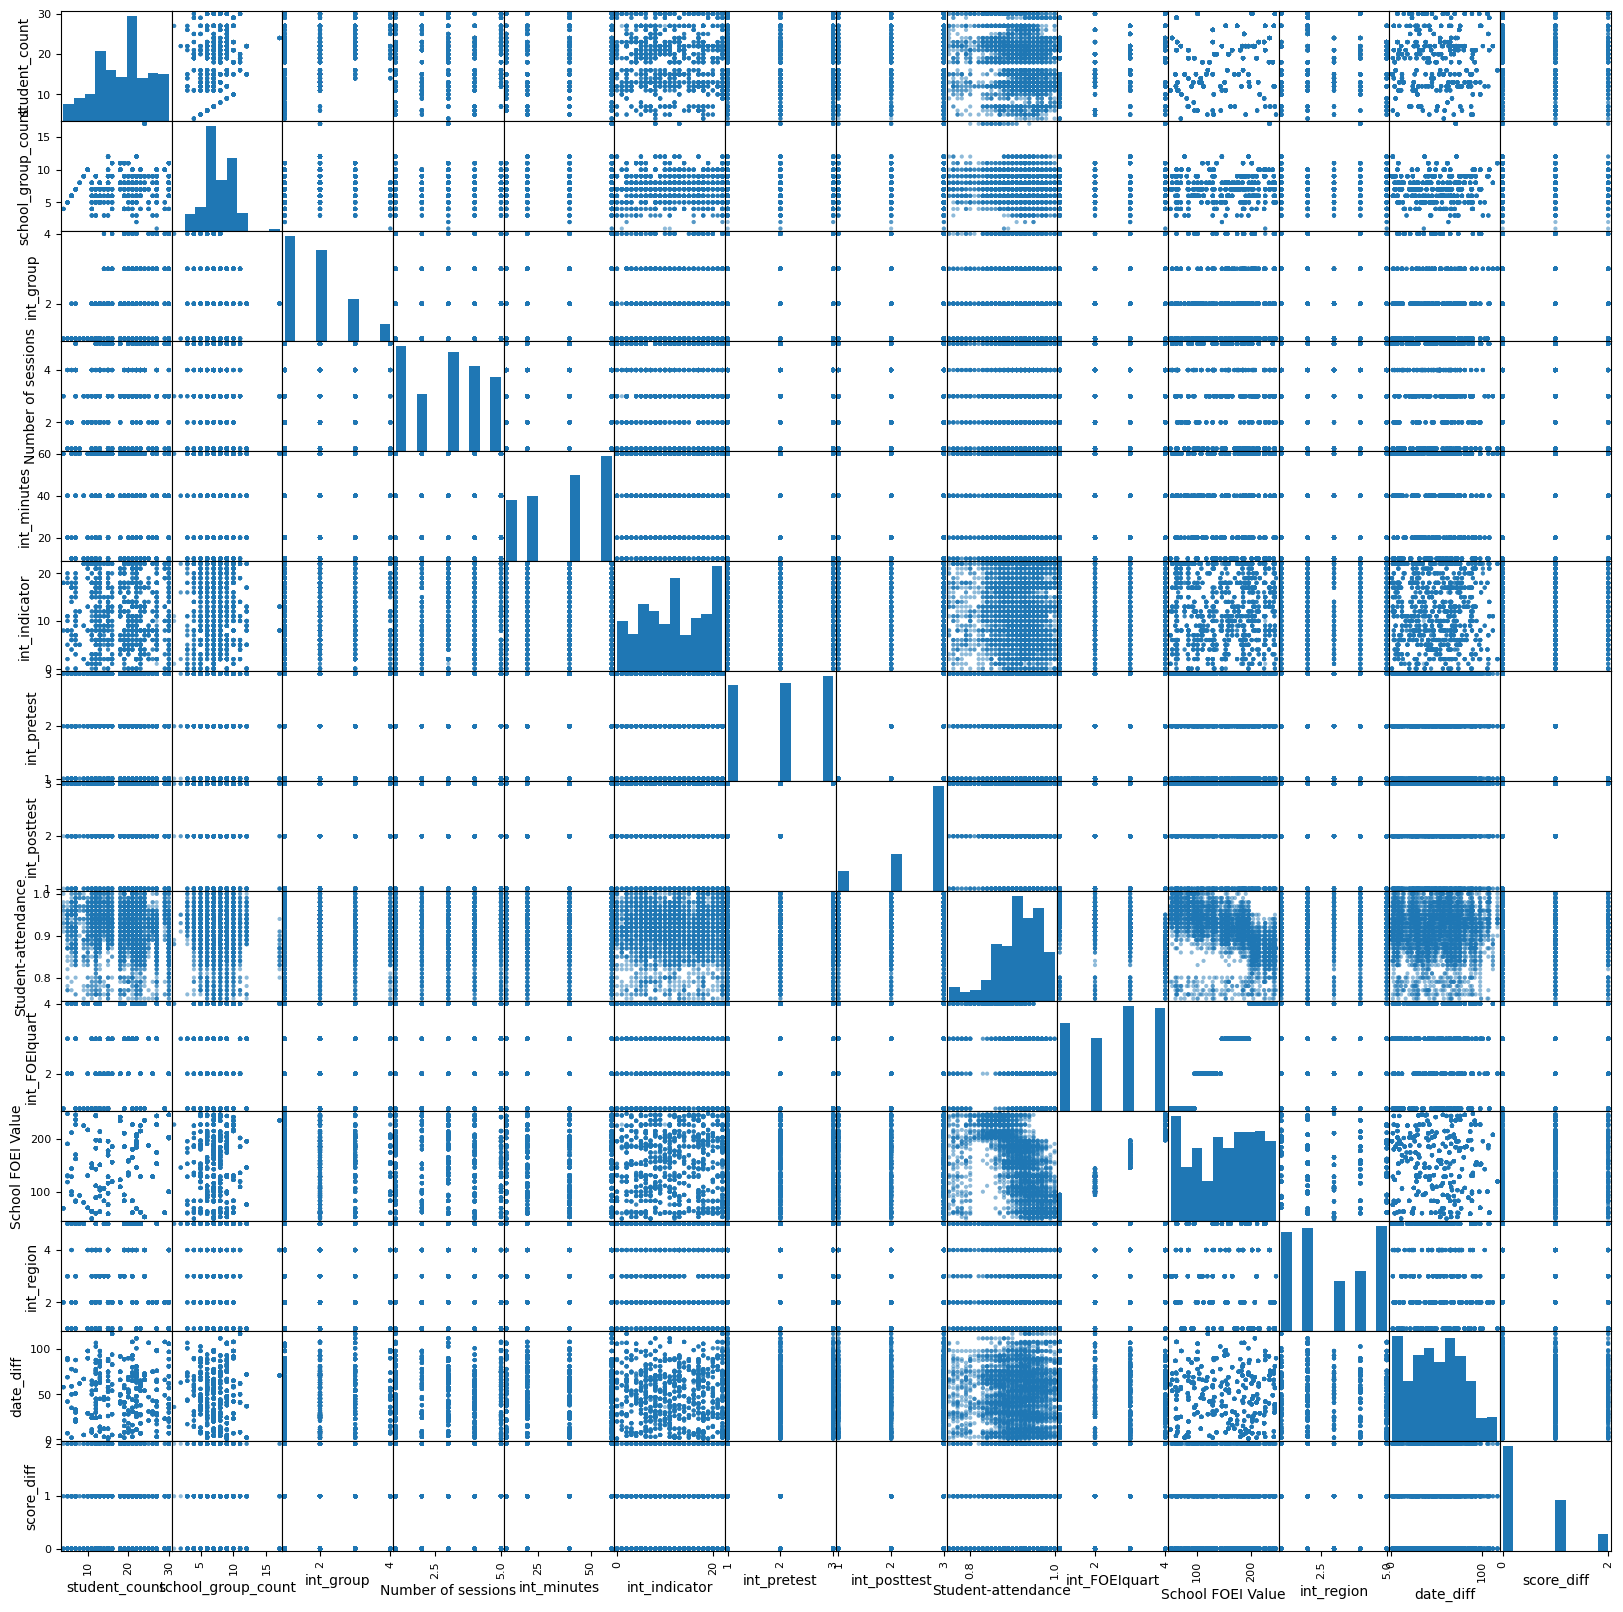

In [27]:
fig = pd.plotting.scatter_matrix(dfs, figsize=(20,20))

In [28]:
dfs.corr()

,student_count,school_group_count,int_group,Number of sessions,int_minutes,int_indicator,int_pretest,int_posttest,Student-attendance,int_FOEIquart,School FOEI Value,int_region,date_diff,score_diff
student_count,1.000000,0.203749,0.419121,0.053247,-0.025064,0.003009,-0.009853,-0.020777,-0.167186,0.263031,0.225817,-0.064674,0.026696,-0.009841
school_group_count,0.203749,1.000000,-0.044456,-0.102311,0.066827,0.039073,-0.018597,-0.023260,-0.075140,0.090919,0.094095,0.007485,0.054743,-0.001756
int_group,0.419121,-0.044456,1.000000,-0.016256,0.042388,0.002737,0.001011,-0.010339,-0.042818,0.097478,0.065899,-0.071450,0.007283,-0.012137
Number of sessions,0.053247,-0.102311,-0.016256,1.000000,0.000421,-0.042685,0.013836,0.019843,0.043242,-0.061747,-0.084206,0.006727,-0.012314,0.003982
int_minutes,-0.025064,0.066827,0.042388,0.000421,1.000000,0.030926,-0.007902,-0.006366,0.049963,-0.078375,-0.042597,-0.009161,-0.036358,0.002962
int_indicator,0.003009,0.039073,0.002737,-0.042685,0.030926,1.000000,0.003382,-0.006710,-0.016534,0.018100,0.029997,-0.082736,-0.005334,-0.011214
int_pretest,-0.009853,-0.018597,0.001011,0.013836,-0.007902,0.003382,1.000000,0.623718,0.009282,0.005068,0.004667,-0.013835,-0.025484,-0.566581
int_posttest,-0.020777,-0.023260,-0.010339,0.019843,-0.006366,-0.006710,0.623718,1.000000,-0.006071,-0.002997,-0.002652,-0.017928,-0.009637,0.290697
Student-attendance,-0.167186,-0.075140,-0.042818,0.043242,0.049963,-0.016534,0.009282,-0.006071,1.000000,-0.571608,-0.558677,0.077130,0.014819,-0.017762
int_FOEIquart,0.263031,0.090919,0.097478,-0.061747,-0.078375,0.018100,0.005068,-0.002997,-0.571608,1.000000,0.967863,-0.133540,-0.018313,-0.009362


#### Correlation observations

Highest correlation is Student attendance and FOEI

Regionality is somewhat correlated to School FOEI amd FOE quartile, student attendance and indicator type may also be worth a look

Date difference in pre and post testing had the highest correlation with regionality 

Student attendance is most correlated with School and quartile FOEI in this dataset

Post test results are most closely correlated to pre test results, which would be expected


Text(197, 0.99, 'Corr coef = -0.55')

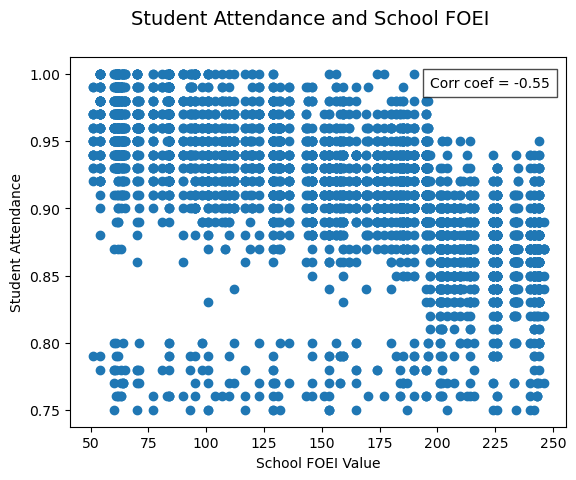

In [29]:
plt.suptitle('Student Attendance and School FOEI',  fontsize=14)
plt.scatter(dfs['School FOEI Value'],dfs['Student-attendance'])
plt.xlabel('School FOEI Value')
plt.ylabel('Student Attendance')
plt.text(
    x=197,  # X-coordinate for the text's bottom-left corner
    y=.99,  # Y-coordinate for the text's bottom-left corner
    s="Corr coef = -0.55",  # The text content
    bbox=dict(
        facecolor='white',  # Background color of the box
        edgecolor='black',      # Border color of the box
        boxstyle='square,pad=0.5', # Box style (e.g., 'round', 'square', 'sawtooth') and padding
        alpha=0.7               # Transparency of the box
    )
)


Text(0, 0.5, 'Outcome Improvement')

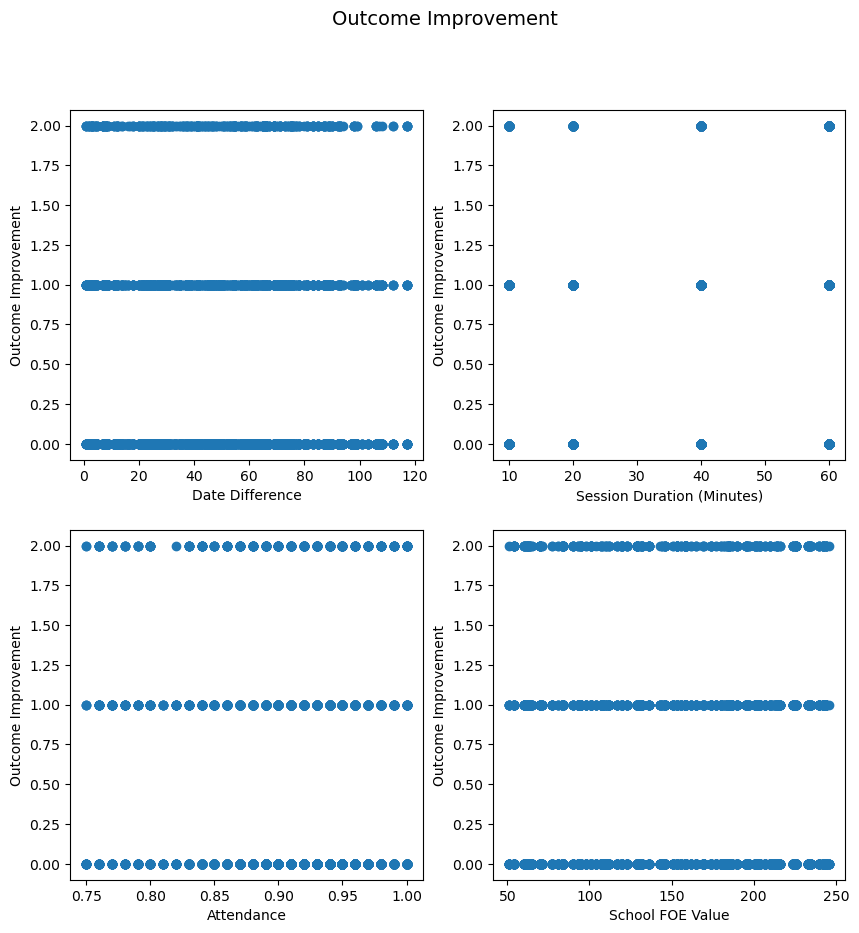

In [30]:
# Generate some larger graphs
plt.figure(figsize=(10, 10))
plt.suptitle('Outcome Improvement',  fontsize=14)
# Upper Left
plt.subplot(221)
plt.scatter(dfs.date_diff,dfs.score_diff)
plt.xlabel('Date Difference')
plt.ylabel('Outcome Improvement')
# Upper Right
plt.subplot(222)
plt.scatter(dfs['int_minutes'],dfs.score_diff)
plt.xlabel('Session Duration (Minutes)')
plt.ylabel('Outcome Improvement')
# Lower Left
plt.subplot(223)
plt.scatter(dfs['Student-attendance'],dfs.score_diff)
plt.xlabel('Attendance')
plt.ylabel('Outcome Improvement')
# Lower Right
plt.subplot(224)
plt.scatter(dfs['School FOEI Value'],dfs.score_diff)
plt.xlabel('School FOE Value')
plt.ylabel('Outcome Improvement')

Text(0, 0.5, 'Test Gap in Days')

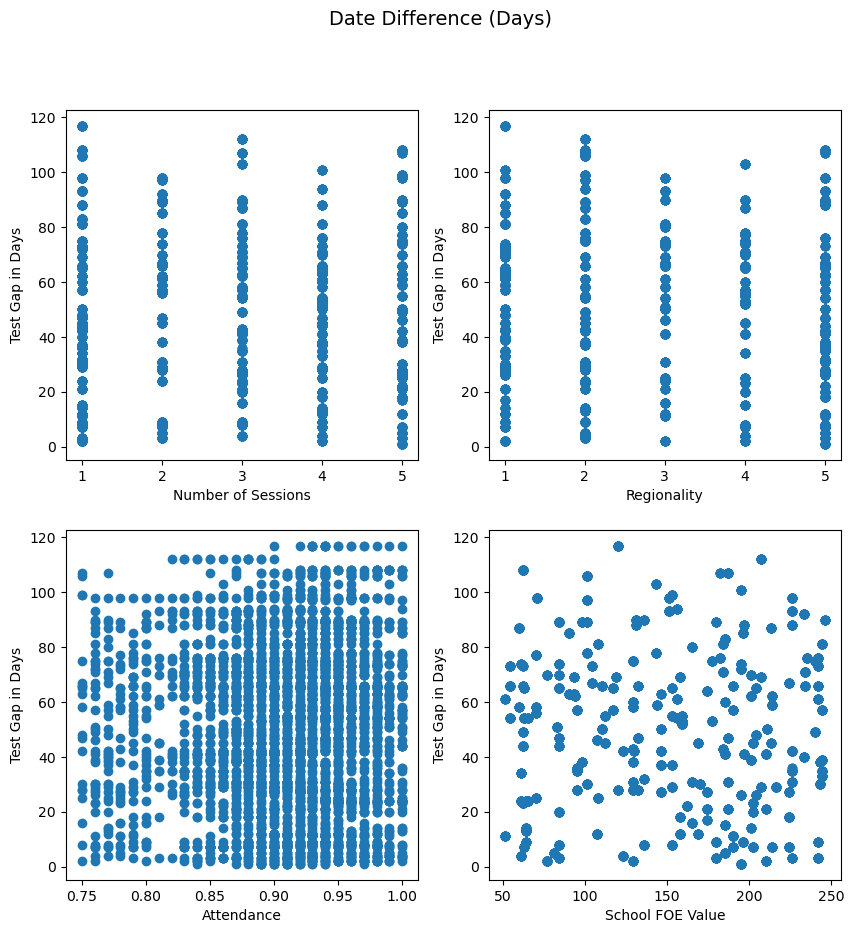

In [31]:
plt.figure(figsize=(10, 10))
plt.suptitle('Date Difference (Days)',  fontsize=14)
# Upper Left
plt.subplot(221)
plt.scatter(dfs['Number of sessions'],dfs.date_diff)
plt.xlabel('Number of Sessions')
plt.ylabel('Test Gap in Days')
# Upper Right
plt.subplot(222)
plt.scatter(dfs.int_region,dfs.date_diff)
plt.xlabel('Regionality')
plt.ylabel('Test Gap in Days')
# Lower Left
plt.subplot(223)
plt.scatter(dfs['Student-attendance'],dfs.date_diff)
plt.xlabel('Attendance')
plt.ylabel('Test Gap in Days')
# Lower Right
plt.subplot(224)
plt.scatter(dfs['School FOEI Value'],dfs.date_diff)
plt.xlabel('School FOE Value')
plt.ylabel('Test Gap in Days')

In [32]:
# Save formatted data for Power BI graphs
df.dtypes

School                          object
Student                         object
Group                           object
Number of sessions               int64
Minutes per session             object
Indicator                       object
Pre-test                        object
Pre-date                        object
Post-test                       object
Post-date                       object
Student-attendance             float64
School FOEI Quartile            object
School FOEI Value                int64
Regionality                     object
fmt_predate             datetime64[ns]
fmt_postdate            datetime64[ns]
date_diff                        int64
int_indicator                    Int64
int_minutes                      int64
int_group                        int64
int_pretest                      int64
int_posttest                     int64
int_FOEIquart                    int64
int_region                       int64
grp_indicator                   object
score_diff               

In [33]:
df.to_csv('num_data.csv')

### Linear Regression

In [34]:
from sklearn.preprocessing import StandardScaler

Y = df[['score_diff']]
X = df[['student_count','Number of sessions','int_minutes','Student-attendance','School FOEI Value','date_diff','school_group_count']].copy() 
#X = df[['Student-attendance','date_diff']].copy() # Try with fewer variables

model = LinearRegression()
# Train the model
model.fit(X, Y)

# Evaluate the model
r2_score = model.score(X, Y)
print(f"R-squared value: {r2_score}")
print("")
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

model = LinearRegression()
model.fit(X, Y)

print("Coefficient (Slope):", model.coef_[0])
print("Intercept:", model.intercept_)
print("")

y_pred = model.predict(X_test)

#predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}) #index mismatch, fix 
#print(predictions.head())
#print(len(y_pred))
#print(len(y_test))
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))
print("")

# Evaluate model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared Score:", r2)

#MAE: Average absolute difference between actual and predicted values. Lower is better.
#MSE: Penalizes larger errors more than MAE. Lower is better.
#R² Score: Explains how well your model fits the data (ranges from 0 to 1). Higher is better.
#X = df_manova[['student_count','Number of sessions','int_minutes','Student-attendance','School FOEI Value','date_diff','school_group_count']].copy()

# very low predictive power!

R-squared value: 0.0013930446456057455

Coefficient (Slope): [-1.05449772e-03  1.94609158e-03  1.45050984e-04 -4.16909848e-01
 -2.71689747e-04  4.98341684e-04 -2.87239061e-04]
Intercept: [0.90109329]

0.0008350858452625953
0.001326449434829735

Mean Absolute Error (MAE): 0.5927666389932588
Mean Squared Error (MSE): 0.43838720332254855
R-squared Score: 0.0008350858452625953


### Distribution chart of continuous variables
To check suitability for variance analysis

In [35]:
cols_hex = np.array(['#E50004','#E22B00','#DF5B00','#DD8900','#DAB700','#CDD800','#9CD500','#6DD300','#3FD000','#12CE00'
              ,'#00CB19','#00C944','#00C66E','#00C496','#00C1BE','#0098BF','#007EBF'])
#,'#0065BF','#004BBF','#0032BF','#0018BF','#0000BF','#1900BF','#3300BF','#4C00BF','#6500BF'
c = cols_hex
bins = 50

C:\Users\User\AppData\Local\Temp\ipykernel_48056\2128509365.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(241)


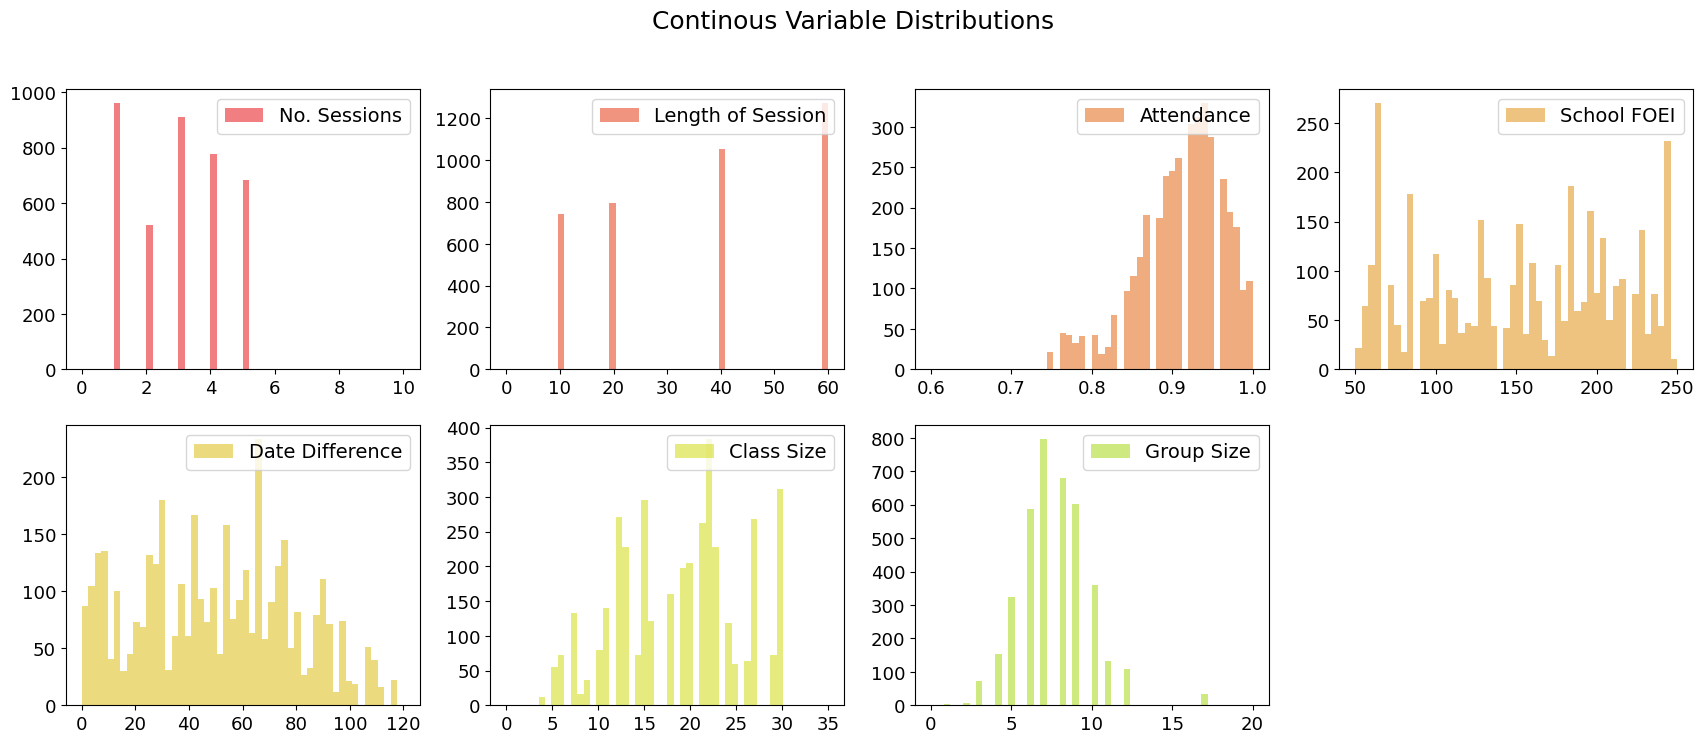

In [36]:
plt.figure(figsize=(21, 8))
plt.suptitle('Continous Variable Distributions',  fontsize=18)
plt.ylabel('Number of Sessions',  fontsize=18)
plt.subplot(241)
plt.hist(df['Number of sessions'], bins, range=(0,10), alpha=0.5, label='No. Sessions', color=c[0])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.title('No. of Sessions')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(242)
plt.hist(df['int_minutes'], bins, range=(0,60), alpha=0.5, label='Length of Session',color=c[1])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.title('length of Session')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(243)
plt.hist(df['Student-attendance'], bins, range=(0.6,1), alpha=0.5, label='Attendance',color=c[2])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.title('Attendance')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(244)
plt.hist(df['School FOEI Value'], bins, range=(50,250), alpha=0.5, label='School FOEI',color=c[3])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.title('School FOEI')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(245)
plt.hist(df['date_diff'], bins, range=(0,120), alpha=0.5, label='Date Difference', color=c[4])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.title('Date Difference')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(246)
plt.hist(df['student_count'], bins, range=(0,35), alpha=0.5, label='Class Size',color=c[5])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.title('Class Size')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(247)
plt.hist(df['school_group_count'], bins, range=(0,20), alpha=0.5, label='Group Size',color=c[6])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.title('Group Size')
plt.legend(loc='upper right',fontsize=14)

### Multivariate ANOVA

In [37]:
from statsmodels.multivariate.manova import MANOVA

In [38]:
df_manova = df[['score_diff','student_count','Number of sessions','int_minutes','Student-attendance','School FOEI Value','date_diff','school_group_count']].copy()

In [39]:
df_manova['score_diff_0'] = np.where(df['score_diff'] ==0 , 1, 0)
df_manova['score_diff_1'] = np.where(df['score_diff'] ==1 , 1, 0)
df_manova['score_diff_2'] = np.where(df['score_diff'] ==2 , 1, 0)

Y = df_manova[['score_diff_0', 'score_diff_1', 'score_diff_2']]
X = df_manova[['student_count','Number of sessions','int_minutes','Student-attendance','School FOEI Value','date_diff','school_group_count']].copy() 

In [40]:
manova = MANOVA(endog=X,
                exog=Y)
result = manova.mv_test()
print(result.summary())

                     Multivariate linear model
                                                                    
--------------------------------------------------------------------
           x0            Value   Num DF   Den DF    F Value   Pr > F
--------------------------------------------------------------------
          Wilks' lambda   0.0031 7.0000 3852.0000 175124.0533 0.0000
         Pillai's trace   0.9969 7.0000 3852.0000 175124.0533 0.0000
 Hotelling-Lawley trace 318.2420 7.0000 3852.0000 175124.0533 0.0000
    Roy's greatest root 318.2420 7.0000 3852.0000 175124.0533 0.0000
--------------------------------------------------------------------
                                                                    
--------------------------------------------------------------------
            x1            Value   Num DF   Den DF   F Value   Pr > F
--------------------------------------------------------------------
           Wilks' lambda   0.0064 7.0000 3852.0000 85828

In [41]:
Y = df_manova[['score_diff']]
manova = MANOVA(endog=X,
                exog=Y)
result = manova.mv_test()
print(result.summary())

                   Multivariate linear model
                                                               
---------------------------------------------------------------
           x0           Value  Num DF   Den DF  F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda 0.6484 7.0000 3854.0000 298.5119 0.0000
         Pillai's trace 0.3516 7.0000 3854.0000 298.5119 0.0000
 Hotelling-Lawley trace 0.5422 7.0000 3854.0000 298.5119 0.0000
    Roy's greatest root 0.5422 7.0000 3854.0000 298.5119 0.0000



### Post-hoc pairwise tests

In [42]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
print('TUKEY PAIRWISE COMPARISONS')
print('')
# Perform Tukey's HSD post-hoc test
tukey_results = pairwise_tukeyhsd(endog=df_manova['int_minutes'],
                                  groups=df_manova['score_diff'],
                                  alpha=0.05)
print('')
print('Session duration (minutes)')
print(tukey_results)
tukey_results = pairwise_tukeyhsd(endog=df_manova['Student-attendance'],
                                  groups=df_manova['score_diff'],
                                  alpha=0.05)
print('')
print('Student Attendance')
print(tukey_results)
tukey_results = pairwise_tukeyhsd(endog=df_manova['student_count'],
                                  groups=df_manova['score_diff'],
                                  alpha=0.05)
print('')
print('Class size')
print(tukey_results)
tukey_results = pairwise_tukeyhsd(endog=df_manova['date_diff'],
                                  groups=df_manova['score_diff'],
                                  alpha=0.05)
print('')
print('Group size')
print(tukey_results)
tukey_results = pairwise_tukeyhsd(endog=df_manova['School FOEI Value'],
                                  groups=df_manova['score_diff'],
                                  alpha=0.05)
print('')
print('School FOEI Value')
print(tukey_results)
tukey_results = pairwise_tukeyhsd(endog=df_manova['Number of sessions'],
                                  groups=df_manova['score_diff'],
                                  alpha=0.05)
print('')
print('Number of Sessions')
print(tukey_results)
tukey_results = pairwise_tukeyhsd(endog=df_manova['school_group_count'],
                                  groups=df_manova['score_diff'],
                                  alpha=0.05)
print('')
print('Group size')
print(tukey_results)

TUKEY PAIRWISE COMPARISONS


Session duration (minutes)
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -0.0078 0.9999 -1.6494 1.6338  False
     0      2   0.2664 0.9665 -2.2477 2.7805  False
     1      2   0.2742  0.969 -2.4169 2.9653  False
---------------------------------------------------

Student Attendance
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -0.0013 0.7775 -0.0059 0.0033  False
     0      2   -0.003 0.5765   -0.01  0.004  False
     1      2  -0.0017 0.8604 -0.0092 0.0058  False
---------------------------------------------------

Class size
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -0.0187 0.996

### Box plots of continuous variables

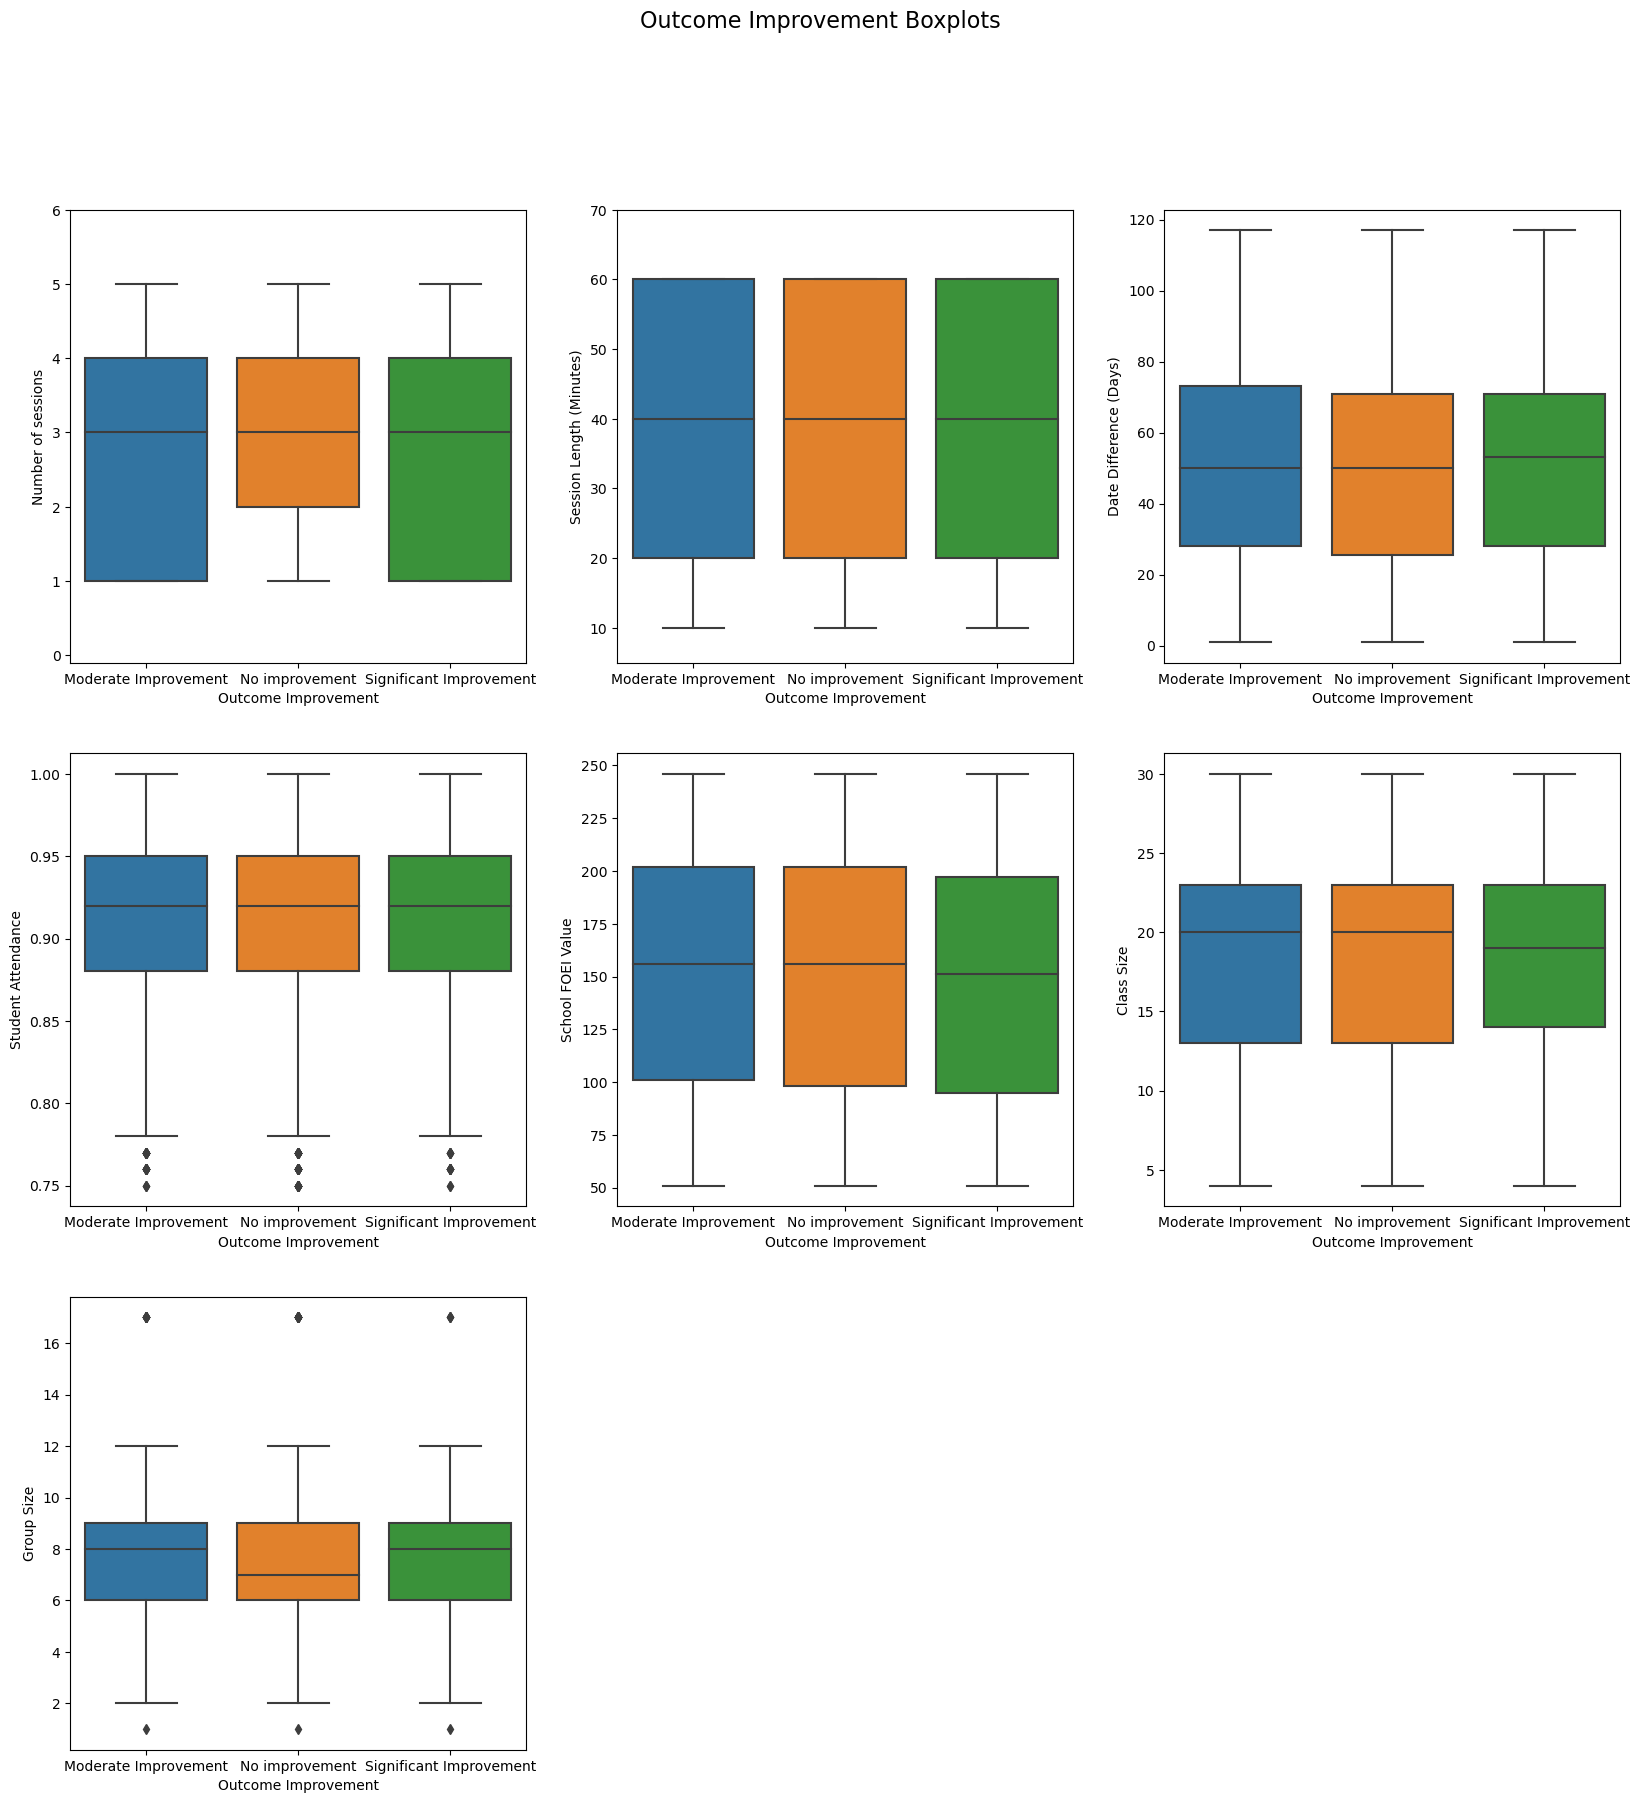

In [43]:

fig, axs = plt.subplots(3,3)
fig.suptitle('Outcome Improvement Boxplots', fontsize=16)

seaborn.boxplot(data=df, x="cat_improvement", y="Number of sessions", ax=axs[0,0]).set(xlabel="Outcome Improvement", ylabel="Number of sessions") 
seaborn.boxplot(data=df, x="cat_improvement", y="int_minutes", ax=axs[0,1]).set(xlabel="Outcome Improvement", ylabel="Session Length (Minutes)") 
seaborn.boxplot(data=df, x="cat_improvement", y="date_diff", ax=axs[0,2]).set(xlabel="Outcome Improvement", ylabel="Date Difference (Days)") 
seaborn.boxplot(data=df, x="cat_improvement", y="Student-attendance", ax=axs[1,0]).set(xlabel="Outcome Improvement", ylabel="Student Attendance") 
seaborn.boxplot(data=df, x="cat_improvement", y="School FOEI Value", ax=axs[1,1]).set(xlabel="Outcome Improvement", ylabel="School FOEI Value") 
seaborn.boxplot(data=df, x="cat_improvement", y="student_count", ax=axs[1,2]).set(xlabel="Outcome Improvement", ylabel="Class Size") 
seaborn.boxplot(data=df, x="cat_improvement", y="school_group_count", ax=axs[2,0]).set(xlabel="Outcome Improvement", ylabel="Group Size") 

axs[0,0].set_ylim(-0.1, 6)
axs[0,1].set_ylim(5, 70)
axs[2,1].axis("off")
axs[2,2].axis("off")

fig.set_figheight(20)
fig.set_figwidth(20)

plt.show()

### Chi square test of independance for Categorical Variables

In [44]:
from scipy.stats import chi2_contingency

print('TEST INDICATOR')
contingency_table = pd.crosstab(df['grp_indicator'], df['cat_improvement'])
print(contingency_table)
chi2, p_value, dof, expected_frequencies = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}")
print('')
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:\n", expected_frequencies)

TEST INDICATOR
cat_improvement  Moderate Improvement  No improvement  Significant Improvement
grp_indicator                                                                 
LS                                103             181                       34
NU                                 77             137                       24
OR                                271             586                      100
PA                                106             229                       28
RF                                201             441                       79
VWT                               190             353                       54
WR                                197             408                       62
Chi-square statistic: 9.258861605087985

P-value: 0.6806756073961675
Degrees of freedom: 12
Expected frequencies:
 [[ 94.3045843  192.31546232  31.37995338]
 [ 70.58016058 143.93421393  23.48562549]
 [283.8034188  578.76068376  94.43589744]
 [107.64957265 219.52991453  35.8

In [45]:
print('TEST REGIONALITY')
contingency_table = pd.crosstab(df['Regionality'], df['cat_improvement'])
print(contingency_table)
print('')
chi2, p_value, dof, expected_frequencies = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:\n", expected_frequencies)

TEST REGIONALITY
cat_improvement            Moderate Improvement  No improvement  \
Regionality                                                       
Inner Regional Australia                    298             570   
Major Cities of Australia                   287             542   
Outer Regional Australia                    136             285   
Remote Australia                            154             346   
Very Remote Australia                       270             592   

cat_improvement            Significant Improvement  
Regionality                                         
Inner Regional Australia                        84  
Major Cities of Australia                       87  
Outer Regional Australia                        44  
Remote Australia                                60  
Very Remote Australia                          106  

Chi-square statistic: 7.069101472513438
P-value: 0.5291958505889764
Degrees of freedom: 8
Expected frequencies:
 [[282.32064232 575.73685574 

In [46]:
print('TEST MAIN EFFECT OF PROGRAM ON OUTCOMES')
contingency_table = pd.crosstab(df['Pre-test'], df['Post-test'])
print(contingency_table)
print('')
chi2, p_value, dof, expected_frequencies = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:\n", expected_frequencies)

TEST MAIN EFFECT OF PROGRAM ON OUTCOMES
Post-test           not observed  observed  partially observed
Pre-test                                                      
not observed                 478       381                 382
observed                       0      1350                   0
partially observed             0       763                 507

Chi-square statistic: 1996.57986014298
P-value: 0.0
Degrees of freedom: 4
Expected frequencies:
 [[153.63843564 801.61978762 285.74177674]
 [167.13286713 872.02797203 310.83916084]
 [157.22869723 820.35224035 292.41906242]]


In [47]:
print('TEST FULL INDICATOR SET')
contingency_table = pd.crosstab(df['Indicator'], df['cat_improvement'])
print(contingency_table)
print('')
chi2, p_value, dof, expected_frequencies = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:\n", expected_frequencies)

TEST FULL INDICATOR SET
cat_improvement  Moderate Improvement  No improvement  Significant Improvement
Indicator                                                                     
LS.P.2                             28              45                       14
LS.P.3                             24              38                        4
LS.P.4                             51              98                       16
NU.P.2                             32              61                        8
NU.P.7                             45              76                       16
OR.P.2                             45             121                       14
OR.P.3                             75             146                       26
OR.P.4                             37              81                       18
OR.P.6                             76             145                       27
OR.P.7                             38              93                       15
PA.P.7                      

In [48]:
print('TEST GROUP')
contingency_table = pd.crosstab(df['Group'], df['cat_improvement'])
print(contingency_table)
print('')
chi2, p_value, dof, expected_frequencies = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:\n", expected_frequencies)

TEST GROUP
cat_improvement  Moderate Improvement  No improvement  Significant Improvement
Group                                                                         
group 1                           454             957                      169
group 2                           422             830                      129
group 3                           191             389                       62
group 4                            78             159                       21

Chi-square statistic: 3.25133422375837
P-value: 0.7767046411917317
Degrees of freedom: 6
Expected frequencies:
 [[468.55736856 955.52965553 155.91297591]
 [409.54286454 835.18130018 136.27583528]
 [190.38850039 388.25951826  63.35198135]
 [ 76.51126651 156.02952603  25.45920746]]
